## Titulo: Predicción de Ranking de las Aplicaciones de Google Play Store

In [1]:
%%capture
!pip install lazypredict
!pip install plotly_express
!pip install category_encoders

In [43]:
# Libreria y funciones usadas para el pproyecto

from pandas import DataFrame, read_csv, set_option, crosstab, to_numeric
set_option('display.max_rows', None)
set_option('display.max_columns', None)
from pandas import crosstab  # tabla de contingencia para usar chi-cuadrado y cramers v
from numpy import concatenate, zeros, nan, sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from category_encoders import CountEncoder, TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split             # Dividir dataset en datos de entrenamiento y de prueba para el modelado
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.metrics import r2_score                            # Importante para evaluar regresion.
from sklearn.metrics import mean_squared_error                  # Me sirve tambien para sacar el RMSE
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import chi2_contingency, kurtosis, skew, shapiro

In [5]:
# Si se quiere usar google.colab descomentar este codigo
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df_google= read_csv(r"C:\Users\gcruz_li35hm9\Desktop\Bootcamp_UDD_Ciencia_de_Datos\Proyecto_7_Bootcamp\Repositorio_Proyecto_7\Data\raw\dataset_googleplaystore.csv")

In [7]:
df_google.head(10)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.10,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.90,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.70,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.50,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.30,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
5,Paper flowers instructions,ART_AND_DESIGN,4.40,167,5.6M,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up
6,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,3.80,178,19M,"50,000+",Free,0,Everyone,Art & Design,"April 26, 2018",1.1,4.0.3 and up
7,Infinite Painter,ART_AND_DESIGN,4.10,36815,29M,"1,000,000+",Free,0,Everyone,Art & Design,"June 14, 2018",6.1.61.1,4.2 and up
8,Garden Coloring Book,ART_AND_DESIGN,4.40,13791,33M,"1,000,000+",Free,0,Everyone,Art & Design,"September 20, 2017",2.9.2,3.0 and up
9,Kids Paint Free - Drawing Fun,ART_AND_DESIGN,4.70,121,3.1M,"10,000+",Free,0,Everyone,Art & Design;Creativity,"July 3, 2018",2.8,4.0.3 and up


In [8]:
df_category = df_google[["Category", "Genres"]].sort_values(by=["Category", "Genres"])
df_category.head()

,Category,Genres
10472,1.9,"February 11, 2018"
0,ART_AND_DESIGN,Art & Design
2,ART_AND_DESIGN,Art & Design
3,ART_AND_DESIGN,Art & Design
5,ART_AND_DESIGN,Art & Design


In [9]:
df_price = df_google[["Type", "Price"]].sort_values(by=["Type", "Price"])
df_price.head()

,Type,Price
10472,0,Everyone
0,Free,0
1,Free,0
2,Free,0
3,Free,0


Antes de partir el desarrollo comenzare planteando el enfoque que le dare a este proyecto. Voy a desarrollar un problema de modelado supervisado usando regresion, basado en la predicción de cuál será el Rating que se le dará a la aplicación.

Convertiré varias columnas de object a int o float luego de analizarlas y limpiarlas:

- A Installs le sacare las "," y "+".

- Size esta en diferentes unidades de medidas (megabytes o M, y kilobytes o k) y posee strings entremedio ("varis with device"). Entonces transformare todo a kilobytes multiplicando los M por 1000, y a los str los reemplazare por la media, ya que literalmente "varies with device" me esta diciendo que esa celda puede tomar diferentes valores dependiendo del dispositivo, razón por la cuál no habría problema en asignarle un valor a partir de la media.

- Reviews también esta sucio (contiene strings) y por este motivo lo transformaré a numerico luego de limpiarlo.

Las demás columnas permaneceran categoricas.


También eliminaré 3 columnas. Estas serán App, Price y Category:

- La columna Price indica el precio de la app, pero no tiene sentido tenerla ya que la columna Type ya me indica si sera pagada o no. entonces basta con quedarse con una de las 2. Usare Chi-cuadrado y Cramer´s V para respaldar esta decisión.
Lo mismo pasa entre Category y Genres pero probablemente con una correlación menor.

- App funciona como un ID, ademas de no aportar información relevante para el modelo, razón por la cuál también la eliminaré.

Category y Genres están sucios (se puede ver en la table de arriba), especificamente en la fila de indice 10472, donde Category posee un número float y Genres una fecha, por lo tanto debere cambiar el contenido de la celda y imputarlo por la moda (en este caso de Genres, ya que Category se eliminara).

Price y Type también tienen una fila que ensucia las columnas, la cual es al igual que el caso de Category y Genres la fila de indice 10472, donde le asigna un 0 tipo str a Type y el str "Everyone" a Price.

Como ya tengo 4 de 13 columnas con datos malos en la misma fila voy a analizar la fila 10472 como un caso particular y probablemente la eliminare completa si hay más fallas.

In [10]:
# Analizando la fila de indice 10472 completa

df_google.iloc[10472]

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                              1.9
Rating                                              19.00
Reviews                                              3.0M
Size                                               1,000+
Installs                                             Free
Type                                                    0
Price                                            Everyone
Content Rating                                        NaN
Genres                                  February 11, 2018
Last Updated                                       1.0.19
Current Ver                                    4.0 and up
Android Ver                                           NaN
Name: 10472, dtype: object

Efectivamente esta fila esta mal:
- En Category posee un dato que no corresponde a la columna.
- En Rating posee un valor muy alto, probablemente un outlier.
- En Review el dato es tipo string y esta escrito de forma muy diferente a como lo esta el resto de la columna
- En Size aparece como los valores que posee Installs (1,000+).
- Installs aparece con un valor como el que debiese ir en Type (Free).
- Price no indica ningun precio, sino que incluye un valor contenido en Content Rating.
- Content Rating posee un NaN.
- Genres posee una fecha
- Last_Updated posee un dato que deberia ir en Current Ver
- Current Ver posee un dato que deberia ir en Android Ver
- Android Ver posee un NaN.

En conclusión hay muchos datos erroneos o faltantes y otros que están probablemente desfasados de variable. Como no sabemos con certeza si realmente están desfazados o no, y la cantidad de columnas erroneas son varias, además de que es solo 1 fila dentro de todo el dataset, lo mejor será borrarla


In [6]:
# Eliminando la fila de indice 10472

df_google.drop(10472, inplace=True)

In [12]:
df_google["Category"].value_counts() # Veo contenido de Category para comparar con Genres

Category
FAMILY                 1972
GAME                   1144
TOOLS                   843
MEDICAL                 463
BUSINESS                460
PRODUCTIVITY            424
PERSONALIZATION         392
COMMUNICATION           387
SPORTS                  384
LIFESTYLE               382
FINANCE                 366
HEALTH_AND_FITNESS      341
PHOTOGRAPHY             335
SOCIAL                  295
NEWS_AND_MAGAZINES      283
SHOPPING                260
TRAVEL_AND_LOCAL        258
DATING                  234
BOOKS_AND_REFERENCE     231
VIDEO_PLAYERS           175
EDUCATION               156
ENTERTAINMENT           149
MAPS_AND_NAVIGATION     137
FOOD_AND_DRINK          127
HOUSE_AND_HOME           88
AUTO_AND_VEHICLES        85
LIBRARIES_AND_DEMO       85
WEATHER                  82
ART_AND_DESIGN           65
EVENTS                   64
PARENTING                60
COMICS                   60
BEAUTY                   53
Name: count, dtype: int64

In [13]:
df_google["Genres"].value_counts() # Veo contenido de Genres

Genres
Tools                                    842
Entertainment                            623
Education                                549
Medical                                  463
Business                                 460
Productivity                             424
Sports                                   398
Personalization                          392
Communication                            387
Lifestyle                                381
Finance                                  366
Action                                   365
Health & Fitness                         341
Photography                              335
Social                                   295
News & Magazines                         283
Shopping                                 260
Travel & Local                           257
Dating                                   234
Books & Reference                        231
Arcade                                   220
Simulation                               200
Cas

La prueba de chi-cuadrado o Cramer´s V se utilizan para determinar si existe una relación significativa entre dos variables categóricas.

Puedo determinarlo usando la función chi2_contingency de scipy.stats

In [7]:
# Defino una función para cramers_v

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


In [8]:
# Defino una función que me generara una matriz de correlacion entre variables categoricas
# Calcular las tablas de contingencia y las correlaciones

def calculate_categorical_correlations(df):
    columns = df.select_dtypes(include=['object']).columns
    n = len(columns)
    correlations = DataFrame(zeros((n, n)), index=columns, columns=columns)

    for i in range(n):
        for j in range(i, n):
            if i == j:
                correlations.iloc[i, j] = 1.0
            else:
                confusion_matrix = crosstab(df[columns[i]], df[columns[j]])
                correlation = cramers_v(confusion_matrix)
                correlations.iloc[i, j] = correlation
                correlations.iloc[j, i] = correlation
    return correlations


In [ ]:
categorical_correlations = calculate_categorical_correlations(df_google)
categorical_correlations

,App,Category,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
App,1.00,0.32,0.00,0.34,0.33,0.33,0.33,0.33,0.32,0.38,0.53,0.33
Category,0.32,1.00,0.21,0.11,0.11,0.20,0.05,0.35,0.97,0.05,0.25,0.09
Reviews,0.00,0.21,1.00,0.00,0.00,0.00,0.00,0.44,0.42,0.00,0.41,0.00
Size,0.34,0.11,0.00,1.00,0.13,0.24,0.17,0.00,0.00,0.51,0.00,0.32
Installs,0.33,0.11,0.00,0.13,1.00,0.27,0.15,0.09,0.11,0.08,0.15,0.10
Type,0.33,0.20,0.00,0.24,0.27,1.00,1.00,0.05,0.26,0.40,0.07,0.19
Price,0.33,0.05,0.00,0.17,0.15,1.00,1.00,0.00,0.00,0.44,0.00,0.09
Content Rating,0.33,0.35,0.44,0.00,0.09,0.05,0.00,1.00,0.38,0.27,0.32,0.05
Genres,0.32,0.97,0.42,0.00,0.11,0.26,0.00,0.38,1.00,0.12,0.31,0.08
Last Updated,0.38,0.05,0.00,0.51,0.08,0.40,0.44,0.27,0.12,1.00,0.00,0.35


Con lo anterior ya tengo comprobada la alta correlacion entre Price vs Type y de Category vs Genres, y respaldada por lo tanto mi decision de eliminar la columna Price y Category.

Ahora pasare al .info() para seguir con un análisis más detallado del dataframe.

In [9]:
df_google = df_google.drop(columns=["App", "Category", "Price"] , axis=1)

In [ ]:
df_google.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10840 entries, 0 to 10840
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rating          9366 non-null   float64
 1   Reviews         10840 non-null  object 
 2   Size            10840 non-null  object 
 3   Installs        10840 non-null  object 
 4   Type            10839 non-null  object 
 5   Content Rating  10840 non-null  object 
 6   Genres          10840 non-null  object 
 7   Last Updated    10840 non-null  object 
 8   Current Ver     10832 non-null  object 
 9   Android Ver     10838 non-null  object 
dtypes: float64(1), object(9)
memory usage: 931.6+ KB


Luego de eliminar las 3 columnas anteriormente mencionadas y la fila que ensuciaba mi dataset queda con 10 columnas y 10840 filas.

El uso de memoria es de 931.6 Kb, lo cual no debiese representar problemas.

Tengo a Rating como mi única columna numérica y de tipo float, y 9 columnas tipo object.

Rating será mi target o variable objetivo. Es una columna numérica de tipo continua, razón por la cual debere usar un análisis y predicción con métodos de regresión.

También puedo ver que hay columnas con valores nulos, las cuales habrá que imputar según criterios que se verán más adelante dependiendo del tipo de dato.

Antes de seguir con cualquier paso debo ver la presencia de duplicados y eliminarlos.

In [15]:
print(f"Tengo {df_google.duplicated().sum()} filas duplicadas")

Tengo 498 filas duplicadas


In [ ]:
columnas_duplicadas=df_google.columns[df_google.columns.duplicated(keep=False)]
if any(columnas_duplicadas):
    print(f"Las columnas duplicadas son {list(columnas_duplicadas)}")
else:
    print("No hay columnas duplicadas en el DF")

No hay columnas duplicadas en el DF


En cuanto a duplicados puedo ver que no tengo ninguna columna duplicada pero si poseo 498 filas duplicadas. Mi número total de filas es de 10840, es decir, estos 498 registros corresponden al 4.59% de las filas de mi dataframe. Con un porcentaje igual o menor a 10% puedo permitirme eliminarlas, requisito que se cumple en este caso.

Antes que nada se deben eliminar los duplicados y luego ver la completitud del dataframe para empezar a trabajar sobre el.

In [10]:
# Identificación de filas duplicadas. Creación de un df con los duplicados
df_duplicated_rows = df_google[df_google.duplicated()]
# print(f"Filas duplicadas:\n{duplicated_rows}\n")

# Número de filas duplicadas
num_duplicated_rows = df_google.duplicated().sum()
#print(f"Número de filas duplicadas: {num_duplicated_rows}")

# Eliminación de filas duplicadas
df_google_sin_duplicados = df_google.drop_duplicates().reset_index(drop=True)

# Verificación del resultado
#print(f"DataFrame sin duplicados:\n{df_google_sin_duplicados}\n")


Ahora pasaré a transformar y analizar mis variables

In [11]:
df_google_sin_duplicados['Type'].value_counts()

Type
Free    9577
Paid     764
Name: count, dtype: int64

In [ ]:
df_google_sin_duplicados['Type'].sort_values() # En el .info() se aprecia un Nulo en Type. Haciendo este codigo lo identificaré

0        Free
6740     Free
6741     Free
6742     Free
6743     Free
6744     Free
6745     Free
6746     Free
6747     Free
6749     Free
6750     Free
6751     Free
6752     Free
6753     Free
6754     Free
6755     Free
6739     Free
6757     Free
6737     Free
6735     Free
6715     Free
6717     Free
6718     Free
6720     Free
6722     Free
6723     Free
6724     Free
6725     Free
6726     Free
6728     Free
6729     Free
6730     Free
6731     Free
6732     Free
6733     Free
6736     Free
6758     Free
6759     Free
6761     Free
6784     Free
6785     Free
6786     Free
6787     Free
6788     Free
6789     Free
6790     Free
6791     Free
6792     Free
6793     Free
6794     Free
6795     Free
6796     Free
6797     Free
6798     Free
6783     Free
6782     Free
6781     Free
6780     Free
6762     Free
6763     Free
6764     Free
6765     Free
6766     Free
6768     Free
6769     Free
6714     Free
6770     Free
6772     Free
6773     Free
6774     Free
6775     Free
6776  

In [17]:
# El indice 8659 contiene el NaN de "Type" asique voy a ver que tiene esa fila para decidir si la elimino o solo imputo el NaN

df_google_sin_duplicados.iloc[8659]

Rating                           NaN
Reviews                            0
Size              Varies with device
Installs                           0
Type                             NaN
Content Rating          Everyone 10+
Genres                      Strategy
Last Updated           June 28, 2018
Current Ver       Varies with device
Android Ver       Varies with device
Name: 8659, dtype: object

La fila 8659 tiene la mayoria de sus valores como corresponde, en consecuencia la conservare ya que solo debo imputar 2 NaN para dejarla bien.

Ahora debo convertir la columna "Size" a una sola unidad, la cual será kilobytes, transformandola en una columna numerica. Como hay un string llamado "Varies with device" entremedio, y ese no lo puedo convertir a kilobytes lo que haré es que a todas las celdas con ese string las reemplazare por la media de la variable Size. Esto lo estoy haciendo porque al decirme que " varia según el dispositivo" quiere decir que esa celda admite diferentes valores dependiendo del dispositivo, por lo tanto no sería errado darle un valor representativo.

Lo mismo haré con Installs, a la cual le sacare los "+" y las ",".

A "Review" también la transformare a numérica

El resto de las columnas quedaran como object.

In [12]:
# Convirtiendo la columna Review:
# Reemplazar caracteres no numéricos y convertir a número
df_google_sin_duplicados['Reviews'] = df_google_sin_duplicados['Reviews'].replace(',', '')

# Verificar que no haya otros caracteres extraños
df_google_sin_duplicados['Reviews'].unique()


array(['159', '967', '87510', ..., '603', '1195', '398307'], dtype=object)

In [13]:
df_google_sin_duplicados['Reviews'] = to_numeric(df_google_sin_duplicados['Reviews'], errors='coerce')

# Verificar que la conversión fue exitosa
print(df_google_sin_duplicados['Reviews'].dtype)
df_google_sin_duplicados[['Reviews']].head()


int64


,Reviews
0,159
1,967
2,87510
3,215644
4,967


In [14]:
# Función para convertir tamaños a kilobytes
def convert_size(size):
    """
    Convierte una cadena de texto que representa el tamaño de una aplicación a un valor numérico en kilobytes.

    Argumentos:
    size -- una cadena que representa el tamaño (por ejemplo, '10M', '500K', 'Varies with device')

    Retorna:
    Un valor numérico en kilobytes o np.nan si el tamaño no es válido o es 'Varies with device'.
    """
    if isinstance(size, str):
        size = size.strip()
        if size.endswith('M'):
            return float(size[:-1]) * 1_000  # Convertir de megabytes a kilobytes
        elif size.endswith('k'):
            return float(size[:-1])  # Eliminar 'k' y convertir a float
        elif size == 'Varies with device':
            return nan
        else:
            try:
                return float(size)
            except ValueError:
                return nan
    return nan

df_google_sin_duplicados['Size'] = df_google_sin_duplicados['Size'].apply(convert_size).astype(float)


In [15]:
# Función para convertir instalaciones a números
def convert_installs(installs):
    if isinstance(installs, str):
        installs_clean = installs.replace(',', '').replace('+', '')
        if installs_clean.isdigit():
            return int(installs_clean)
    return nan

# Aplicar la función de conversión a la columna "Installs"
df_google_sin_duplicados['Installs'] = df_google_sin_duplicados['Installs'].apply(convert_installs).astype(float)  # Use float to handle NaNs


In [16]:
# Completitud de nuestro conjunto de datos.
completitud = DataFrame(df_google_sin_duplicados.isnull().sum())
completitud.reset_index(inplace = True)
completitud = completitud.rename(columns = {"index":"Columna",0:"Total Nulos"})
completitud["Completitud %"] = (1 - completitud["Total Nulos"] / df_google_sin_duplicados.shape[0]) * 100
completitud = completitud.sort_values(by = "Completitud %", ascending = False)
completitud.reset_index(drop = True, inplace = True)
completitud

,Columna,Total Nulos,Completitud %
0,Reviews,0,100.00
1,Installs,0,100.00
2,Content Rating,0,100.00
3,Genres,0,100.00
4,Last Updated,0,100.00
5,Type,1,99.99
6,Android Ver,2,99.98
7,Current Ver,8,99.92
8,Rating,1458,85.90
9,Size,1525,85.25


Con los cambios realizados ahora tengo una completitud de 100% en 5 de las 10 columnas de mi df.

De las 5 columnas con nulos 2 son numéricas (Rating, Size) y 3 object (Type, Android Ver, Current Ver).

Para reemplazar los nulos, en el caso de las columnas flotantes y numéricas , usaré el criterio de comparar la media con la mediana de aquellas columnas incompletas.

Si la media es mayor que la mediana reemplazare por la media.

Si la mediana es mayor que la media reemplazare por la mediana.
Para esto veo el .describe( )

Para rellenar las columnas categoricas debo imputar por la moda

In [ ]:
df_google_sin_duplicados.describe()

,Rating,Reviews,Size,Installs
count,8884.00,10342.00,8817.00,10342.00
mean,4.19,406031.02,21280.53,14165999.12
std,0.52,2698402.98,22548.23,80291926.68
min,1.00,0.00,8.50,0.00
25%,4.00,32.25,4700.00,1000.00
50%,4.30,1686.00,13000.00,100000.00
75%,4.50,46404.25,29000.00,1000000.00
max,5.00,78158306.00,100000.00,1000000000.00


In [17]:
# Separo variables categoricas de las numericas
num_cols=df_google_sin_duplicados.select_dtypes(include=["float64","int64"])

object_cols = df_google_sin_duplicados.select_dtypes(include="object")

In [18]:
# Rellenar columnas categoricas. Debo imputar por la Moda

google_mode= df_google_sin_duplicados[object_cols.columns.tolist()].mode().T
google_mode.reset_index(inplace=True) # Reseteo indices
google_mode = google_mode.rename(columns={"index":"Columna", 0:"Moda"})  # Creo nuevos nombres

google_mode


,Columna,Moda
0,Type,Free
1,Content Rating,Everyone
2,Genres,Tools
3,Last Updated,"August 3, 2018"
4,Current Ver,Varies with device
5,Android Ver,4.1 and up


In [19]:
df_google_sin_duplicados["Rating"]=df_google_sin_duplicados["Rating"].fillna(df_google_sin_duplicados["Rating"].median())
df_google_sin_duplicados["Size"]=df_google_sin_duplicados["Size"].fillna(df_google_sin_duplicados["Size"].mean())

df_google_sin_duplicados["Type"]=df_google_sin_duplicados["Type"].fillna("Free")
df_google_sin_duplicados["Current Ver"]=df_google_sin_duplicados["Current Ver"].fillna("Varies whith device")
df_google_sin_duplicados["Android Ver"]=df_google_sin_duplicados["Android Ver"].fillna("4.1 and up")

In [20]:
# Comprobamos la completitud de nuestro conjunto de datos.
completitud = DataFrame(df_google_sin_duplicados.isnull().sum())
completitud.reset_index(inplace = True)
completitud = completitud.rename(columns = {"index":"Columna",0:"Total Nulos"})
completitud["Completitud %"] = (1 - completitud["Total Nulos"] / df_google_sin_duplicados.shape[0]) * 100
completitud = completitud.sort_values(by = "Completitud %", ascending = False)
completitud.reset_index(drop = True, inplace = True)
completitud

,Columna,Total Nulos,Completitud %
0,Rating,0,100.00
1,Reviews,0,100.00
2,Size,0,100.00
3,Installs,0,100.00
4,Type,0,100.00
5,Content Rating,0,100.00
6,Genres,0,100.00
7,Last Updated,0,100.00
8,Current Ver,0,100.00
9,Android Ver,0,100.00


In [21]:
# Vuelvo a hacer mi .info()

df_google_sin_duplicados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10342 entries, 0 to 10341
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rating          10342 non-null  float64
 1   Reviews         10342 non-null  int64  
 2   Size            10342 non-null  float64
 3   Installs        10342 non-null  float64
 4   Type            10342 non-null  object 
 5   Content Rating  10342 non-null  object 
 6   Genres          10342 non-null  object 
 7   Last Updated    10342 non-null  object 
 8   Current Ver     10342 non-null  object 
 9   Android Ver     10342 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 808.1+ KB


Mi df final quedo con 10342 filas, 10 columnas, de las cuales son 6 object, 1 int, y 3 float.

Mi uso de memoria se redujo de 931.6 Kb a 808.1 Kb

Ahora toca hacer el análisis de las variables y tratar los datos outlier

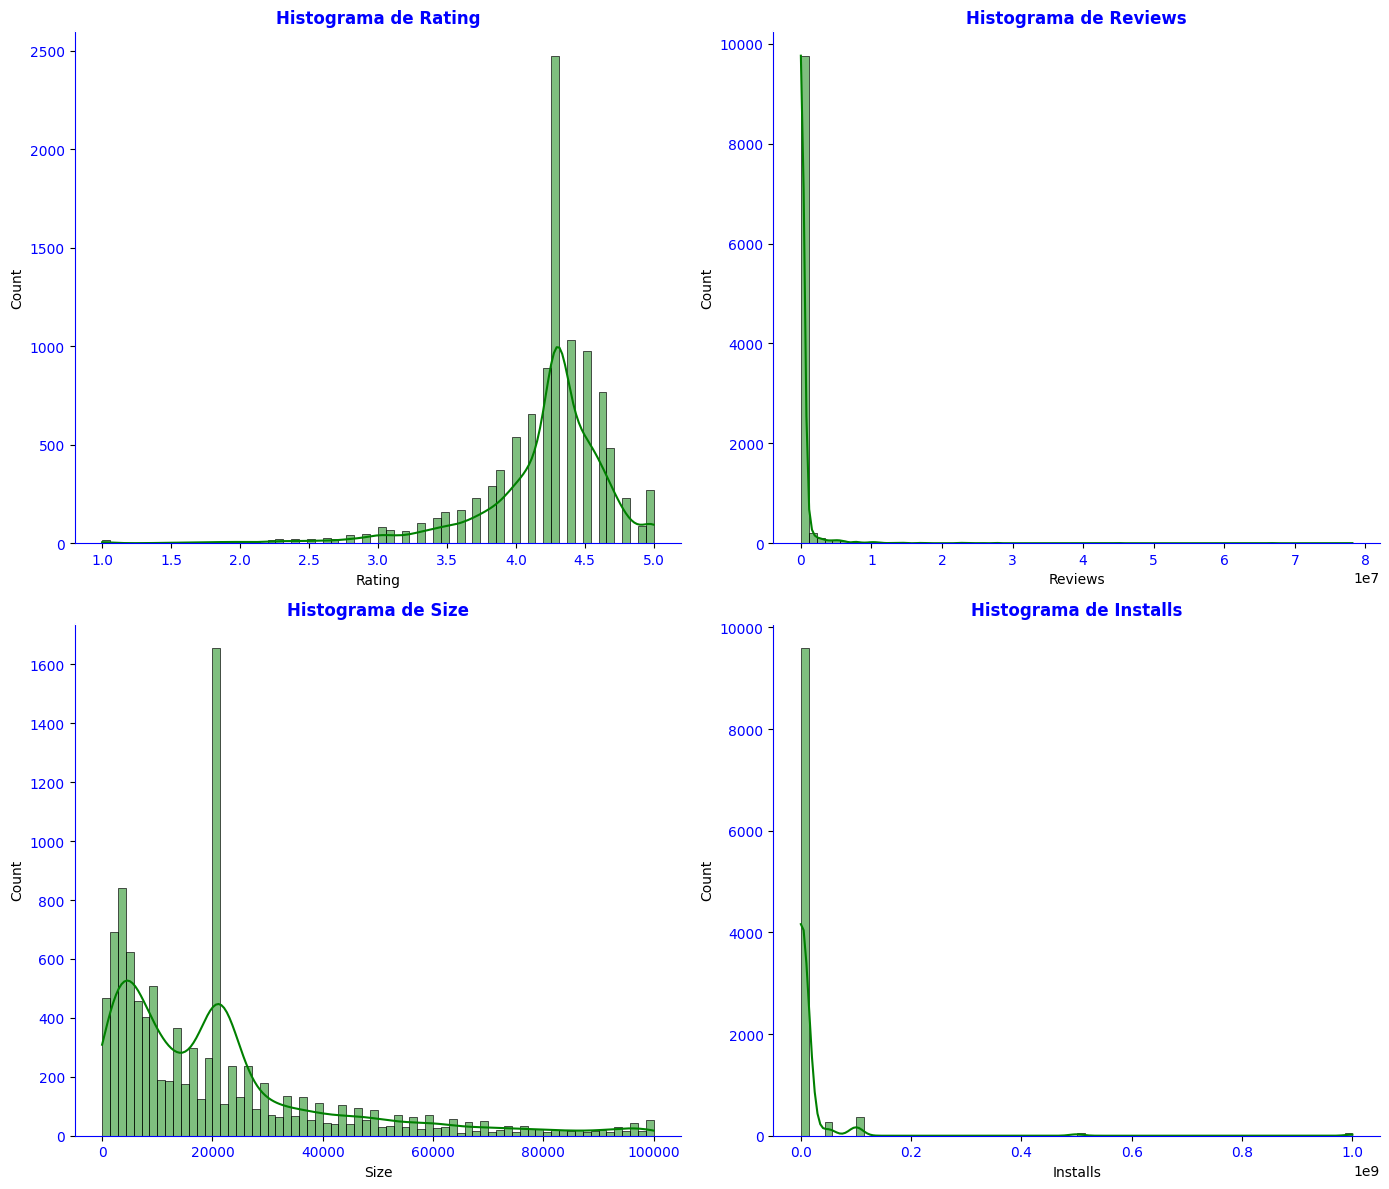

In [35]:
plt.figure(figsize = (14, 12))

# Iterar sobre las columnas numéricas y crear un histograma para cada una
for i, column in enumerate(num_cols, 1):
  plt.subplot(2, 2, i)
  sns.histplot(data = df_google_sin_duplicados[column], bins = 70, color="green", ec="black", kde = True)
  plt.title(f"Histograma de {column}", color = "blue", fontweight = "bold")
  plt.xticks(color="blue")
  plt.yticks(color="blue")
  plt.gca().spines['bottom'].set_color('blue')
  plt.gca().spines['left'].set_color("blue")
  plt.gca().spines['right'].set_color('white')
  plt.gca().spines['top'].set_color("white")

# Ajustar la disposición de los subplots
plt.tight_layout()
plt.show()

In [47]:
for column in df_google_sin_duplicados.columns.to_list():
    kurt = kurtosis(df_google_sin_duplicados[column])
    asimetria = skew(df_google_sin_duplicados[column])
    shapiro_test = shapiro(df_google_sin_duplicados[column])
    print(f"Curtosis columna {column}:", round(kurt, 3))
    print("                                              ")
    print(f"Asimetría columna {column}:", round(asimetria, 3))
    print("                                               ")
    print(f"Shapiro-Wilk columna {column}:", shapiro_test)
    print("-----------------------------------")

Curtosis columna Rating: 7.131
                                              
Asimetría columna Rating: -2.044
                                               
Shapiro-Wilk columna Rating: ShapiroResult(statistic=0.8367153230922505, pvalue=5.4481443690979666e-73)
-----------------------------------
Curtosis columna Reviews: 394.563
                                              
Asimetría columna Reviews: 17.458
                                               
Shapiro-Wilk columna Reviews: ShapiroResult(statistic=0.12314527096813654, pvalue=9.224171177719408e-113)
-----------------------------------
Curtosis columna Size: 2.827
                                              
Asimetría columna Size: 1.701
                                               
Shapiro-Wilk columna Size: ShapiroResult(statistic=0.8148489248889743, pvalue=1.16539111874993e-75)
-----------------------------------
Curtosis columna Installs: 112.653
                                              
Asimetría columna Instal

TypeError: unsupported operand type(s) for /: 'str' and 'int'

Viendo los gráficos y los valores de las métricas de más arriba podemos concluir lo siguiente:

- La columna Rating posee una distribución asimetrica con un sesgo negativo alto y una curtosis alta, es decir, la curva de la distribución se aleja de una curva normal, con una cola izquierda muy larga y puntiaguda y una derecha más cercana a la curva normal. La mayor cantidad de los datos se encuentra en los puntajes altos, alcanzando su máximo alrededor del 4.3, esto nos indica que la mayor cantidad de las aplicaciones están bien evaluadas a pesar de tener algunas con muy bajos puntajes que nos genera esta cola izquierda alargada.

- La columna Reviews posee un caso en que tenemos una asimetría positiva muy alta y una curtosis positiva con valores aún más extremos, lo cual genera una cola derecha muy larga y puntiaguda, dejando una cola izquierda practicamente inexistente como se aprecia en el gráfico que nos muestra casi todos los valores concentrados en los valores bajos.

- En el caso de la variable Size ya con solo ver el gráfico es evidente que no existe una curva normal, ya que posee un alto y un bajo parcial dentro de sus valores de x bajos (alrededor de x = 20.000). Sus valores de asimetría y curtosis son más moderados, donde podemos ver un sesgo positivo que alcanza a ser significativo respecto a la curva normal, sin embargo posee una curtosis positiva moderada, es decir, la diferencia con una distribución normal no es tan lejana estadisticamente, concentrandose sus valores en aquellos más bajos (menores a x = 30.000 aprox), lo cual indica que la mayoria de las apps no son muy pesadas, pero si hay una cantidad significativa de aplicaciónes que ocupan mayor espacio de memoria.

- Para la variable Installs tenemos un caso similar a Reviews pero menos extremo, donde encontramos una curtosis y asimetría muy altas que nos alejan mucho de una curva normal y nos presentan una cola derecha muy larga y puntiaguda, es decir, la mayor cantidad de aplicaciones poseen pocas instalaciones. 

- Todo lo anterior se puede respaldar con la Prueba de Shapiro-Wilk que evalua si la curva sigue una distribucion normal (hipotesis nula) o no. Los valores en "statistic" que estan cercanos a 1 significan que se acercan a la normalidad, y los valores p <= 0,05 indican que los datos son significativamente diferentes a una distribución normal (se rechaza la hipotesis nula). En el caso de nuestros datos todos poseen un valor p exageradamente menor a 0.05, lo que refuerza lo visualizado en los gráficos, especialmente en Reviews y Installs, que ademas poseen un valor de statistic cercano a 0.

- Hay que considerar que estos datos aún poseen los datos atípicos, y dados estos valores se puede suponer a priori que el dataset tiene una gran cantidad de outlier o pocos de ellos pero con valores muy extremos. Esto se confirmara más adelante. 

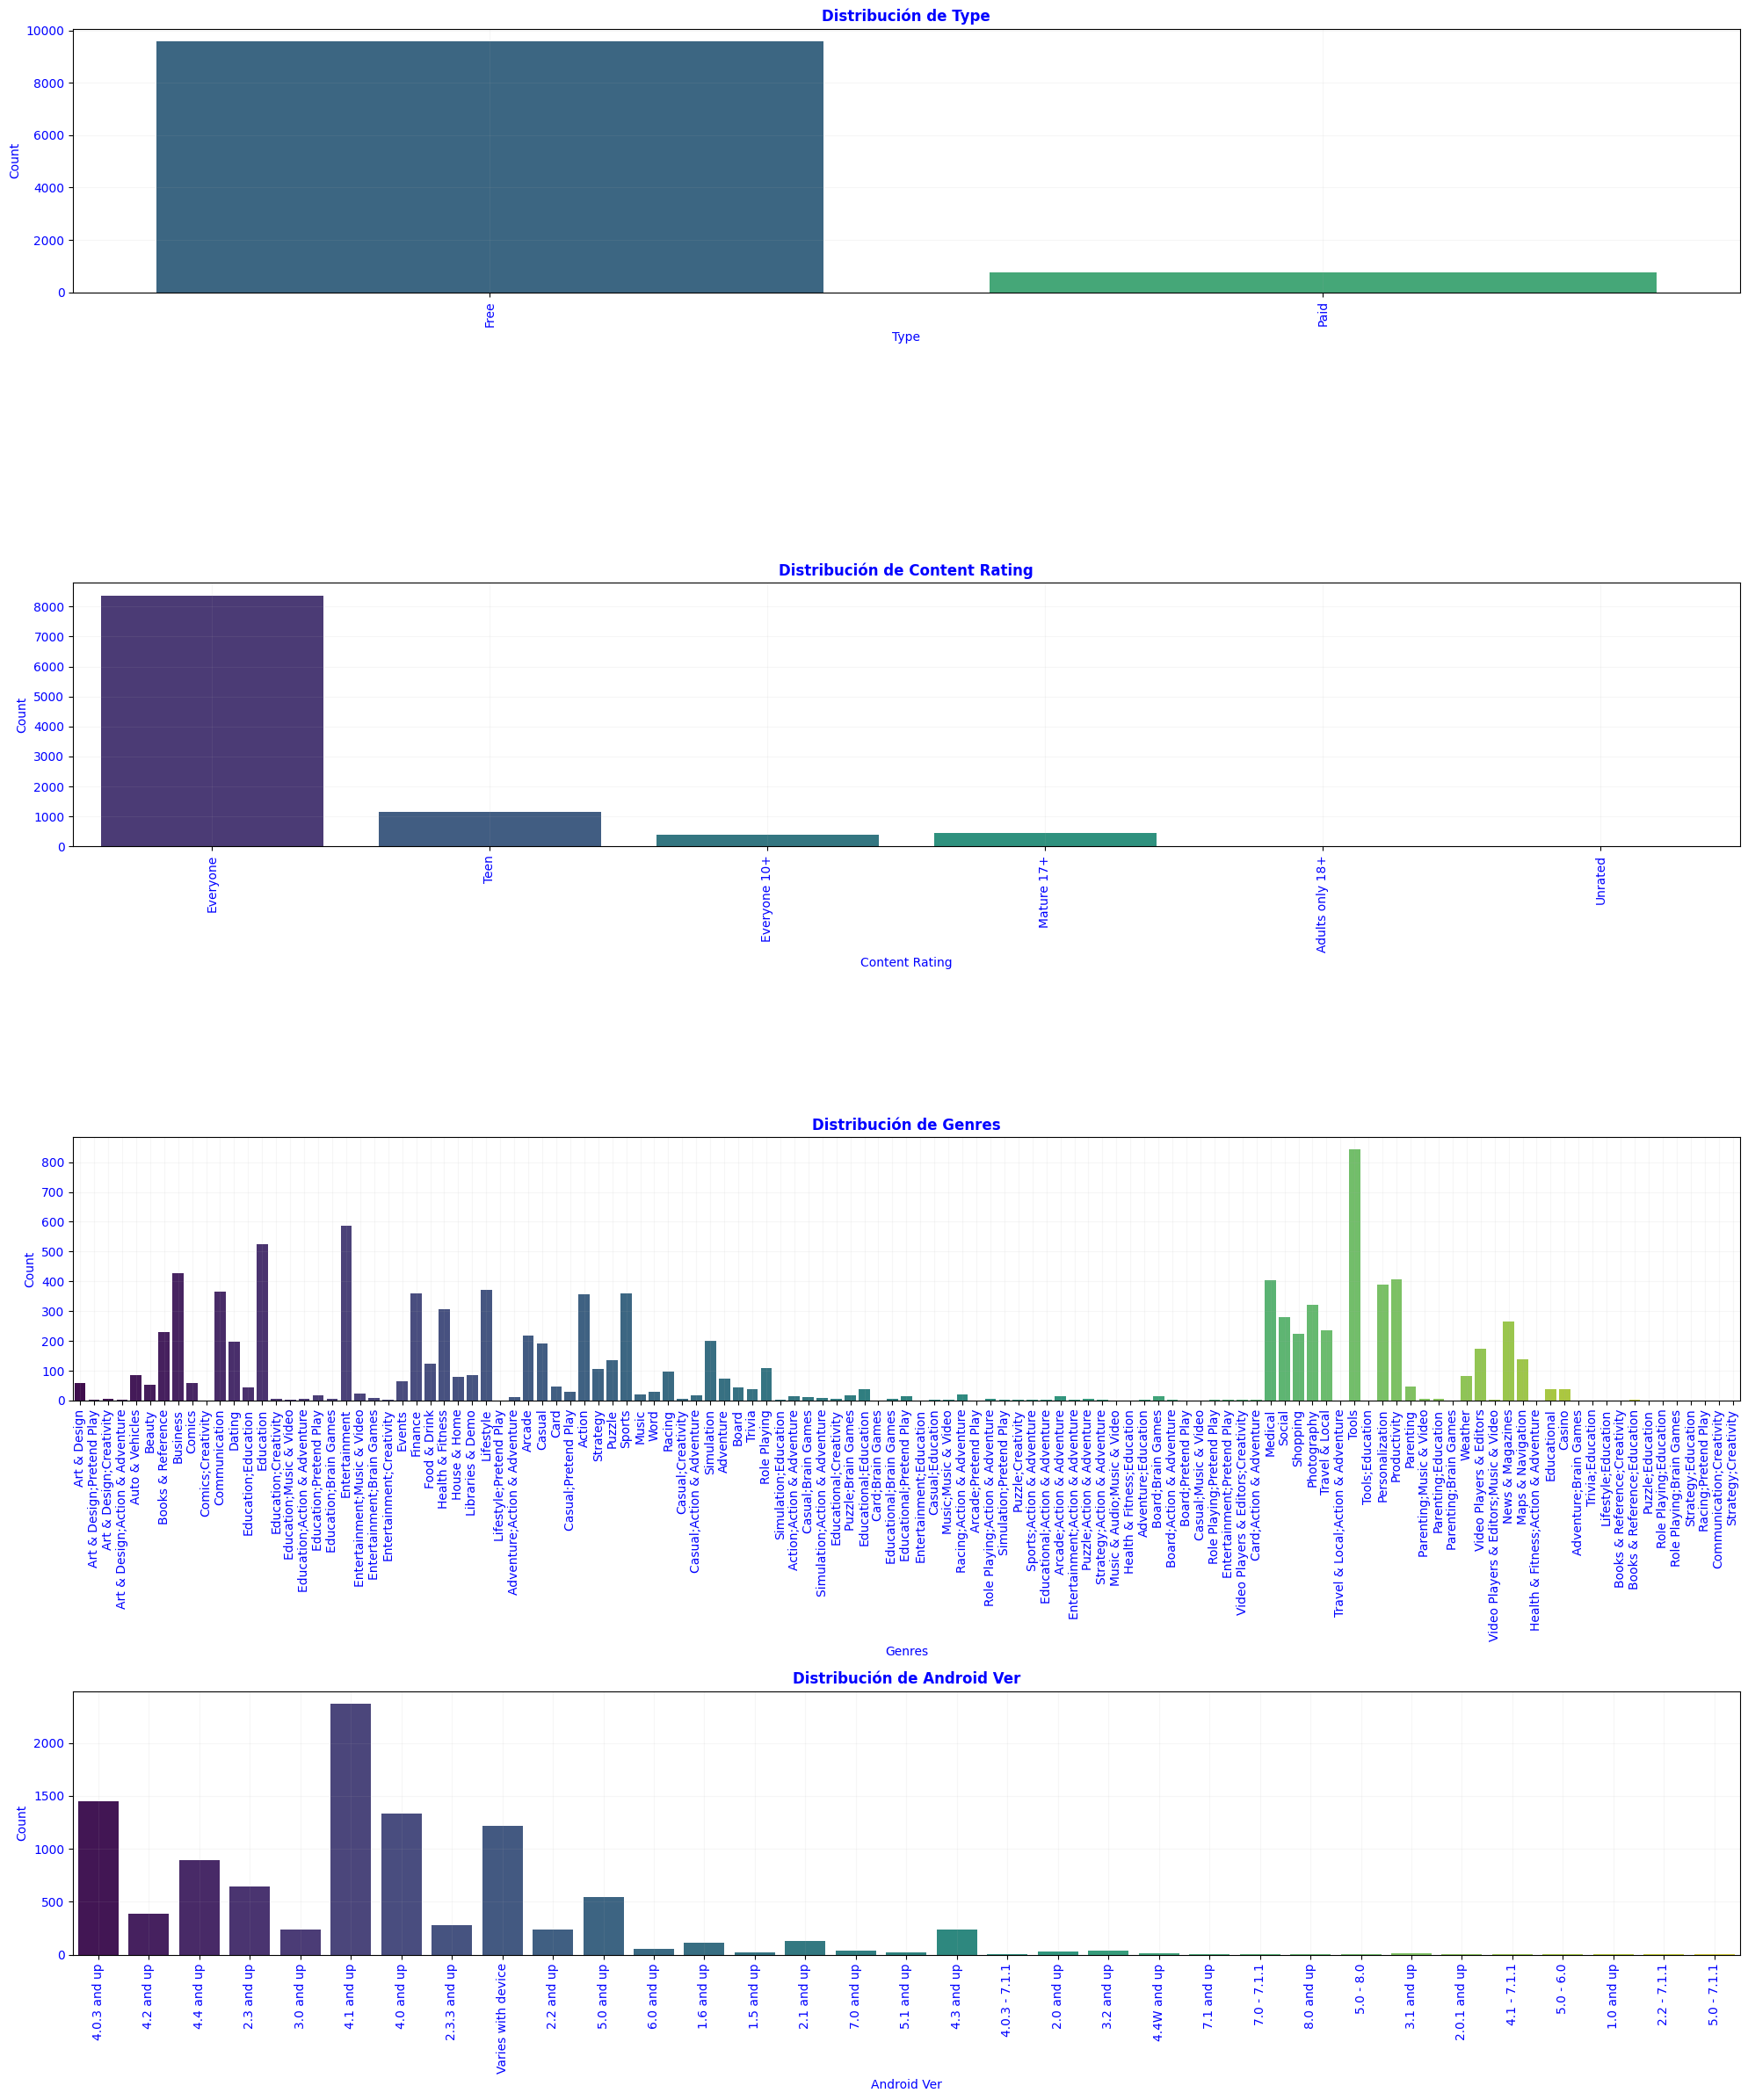

In [52]:
# Distribución y frecuencia de datos categoricos
# Definir tamaño del gráfico
plt.figure(figsize = (20, 24))

# Iterar sobre las columnas numéricas y crear un histograma para cada una
object_cols_2 = ['Type', 'Content Rating', 'Genres', 'Android Ver']

for i, column in enumerate(object_cols_2, 1):
  plt.subplot(4, 1, i)
  sns.countplot(data = df_google_sin_duplicados, x = df_google_sin_duplicados[column], palette = "viridis", alpha = 1, zorder = 1.5)
  plt.title(f"Distribución de {column}", color = "blue", fontweight = "bold")
  plt.xlabel(f"{column}", color ="blue")
  plt.xticks(rotation = 90, color ="blue")
  plt.ylabel("Count", color ="blue")
  plt.yticks(color ="blue")
  plt.grid(True, alpha = 0.1, zorder =0.2)

# Ajustar la disposición de los subplots
plt.tight_layout()
plt.show()

Ahora analizando los datos categoricos nos encontramos con lo siguiente:

- La mayor cantidad de las aplicaciones son gratis, siendo casi 10 veces más que las pagadas.

- También las aplicaciones presentes en el dataset son en su gran mayoria aptas para todo publico y la cantidad para mayores de 18 años son insignificativas en relación a la totalidad del dataset.

In [ ]:
object_cols.columns

Index(['Type', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'Android Ver'],
      dtype='object')

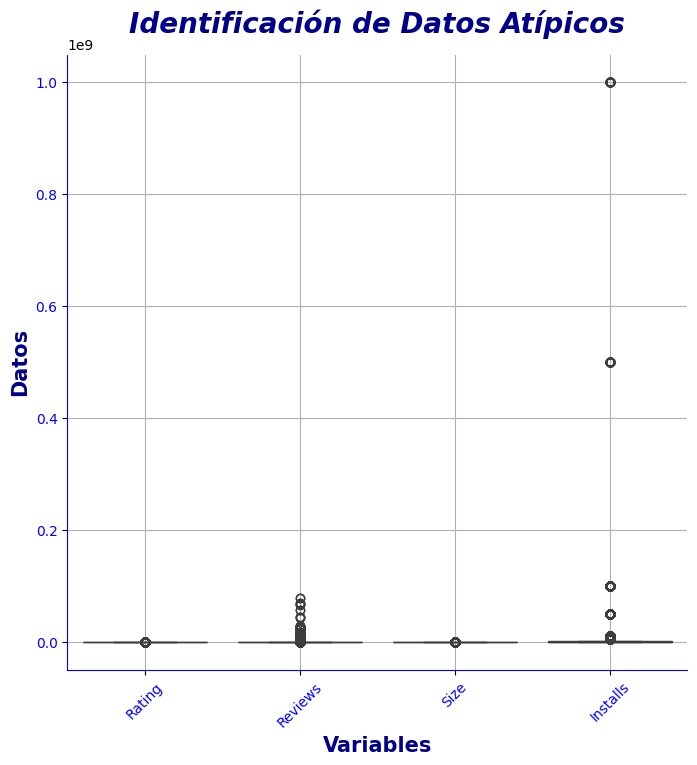

In [ ]:
#  Identificación gráfica de Datos Atípicos.

plt.figure(figsize=(8,8))
sns.boxplot(data=df_google_sin_duplicados)
plt.title("Identificación de Datos Atípicos", fontweight="bold", fontstyle="italic", fontsize=20, pad=15, color="darkblue")
plt.ylabel("Datos", fontweight="bold",fontsize= 15, color="darkblue")
plt.xlabel("Variables", fontweight="bold", fontsize=15, color="darkblue")
plt.xticks(rotation=45, color="blue")
plt.yticks(color="blue")

plt.gca().spines['bottom'].set_color('blue')
plt.gca().spines['left'].set_color("blue")
plt.gca().spines['right'].set_color('white')
plt.gca().spines['top'].set_color("white")

plt.grid()

plt.show()

Acá podemos ver y respaldar lo que antes se podía suponer con el análisis de las distribuciones de los datos de las diferentes variables numéricas, donde las que poseían las colas más largas y puntiagudas y se alejaban más de la curva normal eran Reviews y Install debido a sus valores extremos. 

En el siguiente codigo se aisla cada variable para visualizar más claramente los outlier.

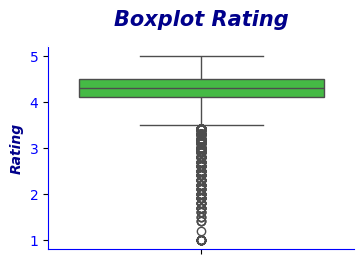

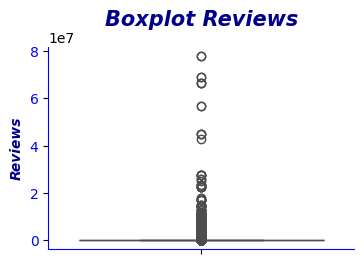

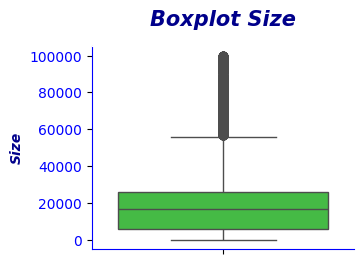

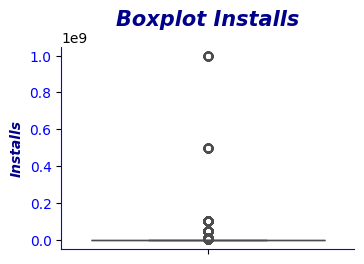

In [ ]:
# Aislar cada boxplot en un gráfico diferente para verlos mejor.
# En el ejemplo col_numeric es una lista con las columnas numéricas.

col_numeric=list(num_cols)

for i in col_numeric:
  plt.figure(figsize=(4, 3))
  sns.boxplot(data=df_google_sin_duplicados[i], color="limegreen")
  plt.title(f"Boxplot {i}", fontweight="bold", fontstyle="italic", fontsize=15, pad=15, color="darkblue")
  plt.ylabel(f"{i}", fontweight="bold", fontstyle="italic", fontsize=10, color="darkblue")
  plt.yticks(color="blue")
  plt.gca().spines['bottom'].set_color('blue')
  plt.gca().spines['left'].set_color("blue")
  plt.gca().spines['right'].set_color('white')
  plt.gca().spines['top'].set_color("white")

  plt.tight_layout(pad=2)


  plt.show()

Ahora analizare por separado usando plotly_express para ver los boxplot con mayor detalle

In [53]:
#  Boxplot Datos Atípicos de la columna Reviews

fig = px.box(df_google_sin_duplicados, y= df_google_sin_duplicados['Reviews'],
             title="Identificación de Datos Atípicos",
             labels={"Reviews": "Reviews", "Valor": "Valor"},
             )

# Personalizar el diseño del grafico (fig.update_layout())

fig.update_layout(title=dict(text="Identificación de Datos Atípicos en Reviews",
                              font=dict(size=35, color="blue", family="Arial"),           # size me determina el tamaño del titulo
                              pad=dict(b=30, l=0, r=0, t=30), x=0.5),                     # X=0.5  me centra el titulo en el gráfico
                  xaxis=dict(title=dict(text= "Reviews", font=dict(color="blue", size=20, family="Arial")),  # Personalizo label del eje X
                              showline=True, linewidth=1, linecolor='blue',                                   # Para ver la linea del eje X y personalizarla
                              tickfont=dict(color='blue', size=16)),                                          # Personalizo ticks del eje X
                  yaxis=dict(title=dict(text="Valor Reviews", font=dict(color="blue", size=20, family="Arial")),
                              showline=True, linewidth=1, linecolor='blue',
                              tickfont=dict(color='blue', size=16)),
                  paper_bgcolor="white",                                           # Establece el color de fondo del área del papel.
                  plot_bgcolor="white")                                            # Establece el color de fondo del área del gráfico

#  Personalizar color y bordes del boxplot (fig.update_traces( ))
fig.update_traces(marker=dict(color='green', line=dict(color='black', width=1)))

# Mostrar el gráfico
fig.show()

In [54]:
df_reviews= DataFrame(df_google_sin_duplicados["Reviews"]).value_counts().reset_index()
df_reviews.sort_values(by="Reviews", ascending=False). head(100)

,Reviews,count
6000,78158306,1
2427,78128208,1
2428,69119316,1
2429,69109672,1
2430,66577446,1
2431,66577313,1
2432,66509917,1
2433,56646578,1
2434,56642847,1
2435,44893888,1


Acá imputaré los outlier por el valor_maximo.


In [55]:
#  Boxplot Datos Atípicos de la columna Size

fig = px.box(df_google_sin_duplicados, y= df_google_sin_duplicados['Size'],
             title="Identificación de Datos Atípicos",
             labels={"Size": "Size (kb)", "Valor": "Valor"},
             )

# Personalizar el diseño del gráfico (fig.update_layout())

fig.update_layout(title=dict(text="Identificación de Datos Atípicos en Size",
                              font=dict(size=35, color="blue", family="Arial"),           # size me determina el tamaño del titulo
                              pad=dict(b=30, l=0, r=0, t=30), x=0.5),                     # X=0.5  me centra el titulo en el gráfico
                  xaxis=dict(title=dict(text= "Size", font=dict(color="blue", size=20, family="Arial")),  # Personalizo label del eje X
                              showline=True, linewidth=1, linecolor='blue',                                   # Para ver la linea del eje X y personalizarla
                              tickfont=dict(color='blue', size=16)),                                          # Personalizo ticks del eje X
                  yaxis=dict(title=dict(text="Kilobytes", font=dict(color="blue", size=20, family="Arial")),
                              showline=True, linewidth=1, linecolor='blue',
                              tickfont=dict(color='blue', size=16)),
                  paper_bgcolor="white",                                           # Establece el color de fondo del área del papel.
                  plot_bgcolor="white")                                            # Establece el color de fondo del área del gráfico

#  Personalizar color y bordes del boxplot (fig.update_traces( ))
fig.update_traces(marker=dict(color='green', line=dict(color='black', width=1)))

# Mostrar el gráfico
fig.show()

In [56]:
df_size= DataFrame(df_google_sin_duplicados["Size"]).value_counts().reset_index()
df_size.sort_values(by="Size", ascending=False).head(100)

,Size,count
156,100000.00,16
85,99000.00,38
161,98000.00,15
151,97000.00,19
139,96000.00,25
155,95000.00,17
162,94000.00,15
163,93000.00,15
166,92000.00,14
149,91000.00,21


En Size no podemos eliminar datos atípicos, ya que si bien los tamaños grandes caen fuera del bigote, no se observa un comportamiento atípico, en que el valor se vea claramente aislado del resto de los datos, por el contrario, podemos observar un dato seguido por el otro.
Por el motivo anterior conservare estos datos outlier y los imputare por el valor_max.

In [57]:
#  Boxplot Datos Atípicos de la columna Install

fig = px.box(df_google_sin_duplicados, y= df_google_sin_duplicados['Installs'],
             title="Identificación de Datos Atípicos",
             labels={"Installs": "Installs", "Valor": "Valor"},
             )

# Personalizar el diseño del gráfico (fig.update_layout())

fig.update_layout(title=dict(text="Identificación de Datos Atípicos en Installs",
                              font=dict(size=35, color="blue", family="Arial"),           # size me determina el tamaño del titulo
                              pad=dict(b=30, l=0, r=0, t=30), x=0.5),                     # X=0.5  me centra el titulo en el gráfico
                  xaxis=dict(title=dict(text= "Installs", font=dict(color="blue", size=20, family="Arial")),  # Personalizo label del eje X
                              showline=True, linewidth=1, linecolor='blue',                                   # Para ver la linea del eje X y personalizarla
                              tickfont=dict(color='blue', size=16)),                                          # Personalizo ticks del eje X
                  yaxis=dict(title=dict(text="Valor Installs", font=dict(color="blue", size=20, family="Arial")),
                              showline=True, linewidth=1, linecolor='blue',
                              tickfont=dict(color='blue', size=16)),
                  paper_bgcolor="white",                                           # Establece el color de fondo del área del papel.
                  plot_bgcolor="white")                                            # Establece el color de fondo del área del gráfico

#  Personalizar color y bordes del boxplot (fig.update_traces( ))
fig.update_traces(marker=dict(color='green', line=dict(color='black', width=1)))

# Mostrar el gráfico
fig.show()

In [ ]:
df_installs= DataFrame(df_google_sin_duplicados["Installs"]).value_counts().reset_index()
df_installs.sort_values(by="Installs", ascending=False)


,Installs,count
18,1000000000.00,49
17,500000000.00,61
11,100000000.00,368
13,50000000.00,272
1,10000000.00,1130
6,5000000.00,682
0,1000000.00,1486
7,500000.00,517
2,100000.00,1128
8,50000.00,473


Acá imputaré los datos atípicos por el valor_max.

In [58]:
#  Boxplot Datos Atípicos de la columna Rating

fig = px.box(df_google_sin_duplicados, y= df_google_sin_duplicados['Rating'],
             title="Identificación de Datos Atípicos",
             labels={"Rating": "Rating", "Valor": "Valor"},
             )

# Personalizar el diseño del gráfico (fig.update_layout())

fig.update_layout(title=dict(text="Identificación de Datos Atípicos según Rating",
                              font=dict(size=35, color="blue", family="Arial"),           # size me determina el tamaño del titulo
                              pad=dict(b=30, l=0, r=0, t=30), x=0.5),                     # X=0.5  me centra el titulo en el gráfico
                  xaxis=dict(title=dict(text= "Rating", font=dict(color="blue", size=20, family="Arial")),  # Personalizo label del eje X
                              showline=True, linewidth=1, linecolor='blue',                                   # Para ver la linea del eje X y personalizarla
                              tickfont=dict(color='blue', size=16)),                                          # Personalizo ticks del eje X
                  yaxis=dict(title=dict(text="Valor Rating", font=dict(color="blue", size=20, family="Arial")),
                              showline=True, linewidth=1, linecolor='blue',
                              tickfont=dict(color='blue', size=16)),
                  paper_bgcolor="white",                                           # Establece el color de fondo del área del papel.
                  plot_bgcolor="white")                                            # Establece el color de fondo del área del gráfico

#  Personalizar color y bordes del boxplot (fig.update_traces( ))
fig.update_traces(marker=dict(color='green', line=dict(color='black', width=1)))

# Mostrar el gráfico
fig.show()

Acá en Rating observo una continuidad en los datos atípicos. Como esta variable es mi Target debo mantenerla tal como está.

In [ ]:
df_rating= DataFrame(df_google_sin_duplicados["Rating"]).value_counts().reset_index()
df_rating.sort_values(by="Rating", ascending=True)

,Rating,count
28,1.00,16
38,1.20,1
37,1.40,3
36,1.50,3
35,1.60,4
34,1.70,8
33,1.80,8
31,1.90,12
30,2.00,12
32,2.10,8


Para eliminar los outlier definiré una formula que imputará los valores atipicos por el valor_max si los outlier superan el valor máximo, o por el valor_min si los outlier están bajo el valor mínimo.

Realizaré la imputación con todas las columnas numéricas excepto con Rating, ya que esta variable es mi Target y no debo tocarla.

In [59]:
def imputar_outliers(df, columns):
    def rango_intercuartilico(columna):
        Q1 = columna.quantile(0.25)
        Q3 = columna.quantile(0.75)
        IQR = Q3 - Q1
        valor_min = Q1 - (1.5 * IQR)
        valor_max = Q3 + (1.5 * IQR)
        return valor_min, valor_max

    for col in columns:
        inf, sup = rango_intercuartilico(df[col])
        df[col] = df[col].apply(lambda x: inf if x < inf else sup if x > sup else x)

    return df

In [60]:
# Uso de la función
columns = ['Reviews', 'Size', 'Installs']
df_google_sin_duplicados = imputar_outliers(df_google_sin_duplicados, columns)

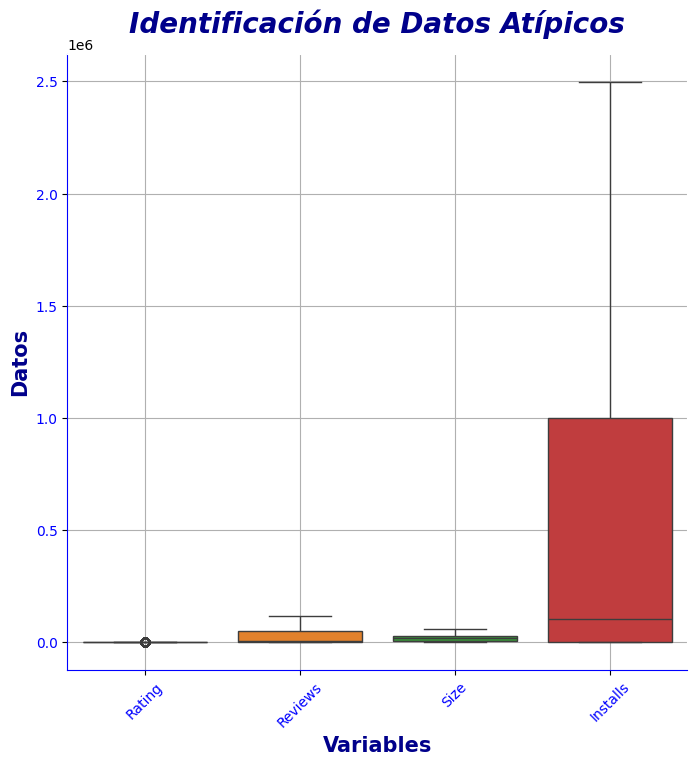

In [61]:
#  Compruebo limpieza de Outliers.

plt.figure(figsize=(8,8))
sns.boxplot(data=df_google_sin_duplicados)
plt.title("Identificación de Datos Atípicos", fontweight="bold", fontstyle="italic", fontsize=20, pad=15, color="darkblue")
plt.ylabel("Datos", fontweight="bold",fontsize= 15, color="darkblue")
plt.xlabel("Variables", fontweight="bold", fontsize=15, color="darkblue")
plt.xticks(rotation=45, color="blue")
plt.yticks(color="blue")

plt.gca().spines['bottom'].set_color('blue')
plt.gca().spines['left'].set_color("blue")
plt.gca().spines['right'].set_color('white')
plt.gca().spines['top'].set_color("white")

plt.grid()

plt.show()

In [62]:
target = df_google_sin_duplicados["Rating"]

# Especificar colores para cada categoría
color = {"Rating": "salmon"}

fig = px.histogram(target, nbins=45, opacity=0.8,
                   title="Histograma Frecuencia de Postulación a un Determinado Salario",
                   labels={"Rating": "Rating Apps Google Play Store", "count": "Frecuencia"},
                   marginal="rug",
                   color_discrete_map= color
                   )

fig.update_layout(title=dict(text="Histograma Frecuencia de Puntuación según Rating",
                              font=dict(size=35, color="blue", family="Arial"),
                              pad=dict(b=30, l=0, r=0, t=30), x=0.5),
                  xaxis=dict(title=dict(text="Rating", font=dict(color="blue", size=20, family="Arial")),
                              showline=True, linewidth=1, linecolor='blue',
                              tickfont=dict(color='blue', size=16)),
                  yaxis=dict(title=dict(text="Frecuencia de Puntuación", font=dict(color="blue", size=20, family="Arial")),
                              showline=True, linewidth=1, linecolor='blue',
                              tickfont=dict(color='blue', size=16)),
                  showlegend=True,
                  legend=dict(x=0, y=1, traceorder="reversed", orientation="v", # Posición superior izquierda
                              font=dict(color="purple", size=14)),  # Color púrpura para el texto de la leyenda
                  paper_bgcolor="white",
                  plot_bgcolor="white")

# Personalizar bordes de las barras
fig.update_traces(marker=dict(line=dict(color='black', width=1)))

# Mostrar el gráfico
fig.show()

La mayor cantidad de datos se concentra en el ranking 4,3.

La distribución tiene una forma de campana de gauss, sin embargo se aleja de una distribución normal de datos. Esto se visualiza al observar la cola izquierda mucho más alargada y puntiaguada que la derecha en el gráfico y es respaldado por los resultados obtenidos de las métricas de Curtosis, Asimetría y Prueba de Shapiro-Wilk (ver más arriba).

Lo anterior me dice que la mayoría de las aplicaciones del dataset de google son clasificadas con una buena nota, siendo un número reducido las calificadas con puntajes bajos, sin embargo este número reducido esta distribuido en un rango muy amplio y alcanza puntajes muy bajos (de 1 a 3) lo que causa que la curva salga de una distribución normal.

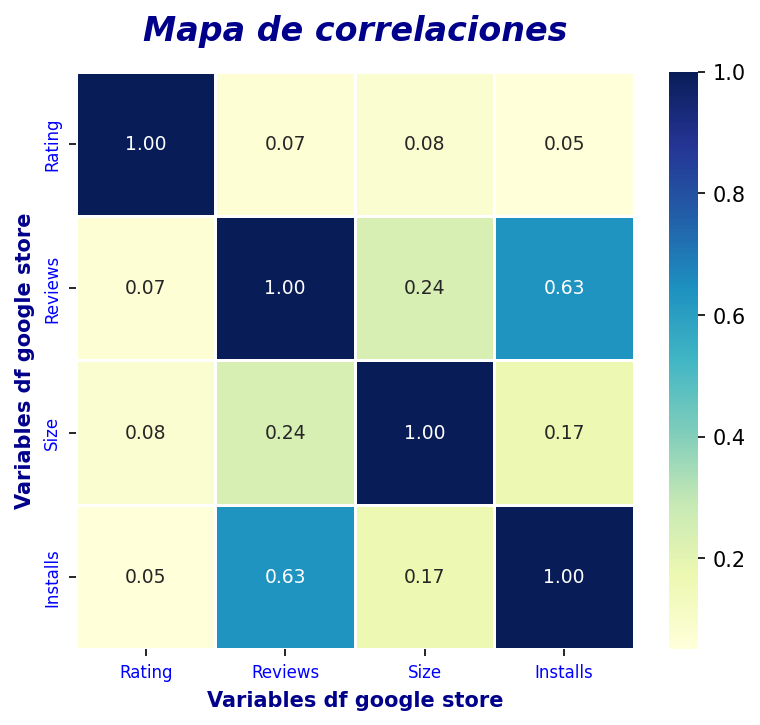

In [ ]:
# Creo un mapa de calor para ver correlaciones numéricas

correlaciones = num_cols.corr()
plt.figure(figsize=(6,5), dpi=150)
sns.heatmap(correlaciones, annot=True, linewidths=0.5, cmap="YlGnBu", fmt=".2f", annot_kws={"size":9})

plt.title("Mapa de correlaciones", fontstyle="italic", fontweight="bold", fontsize= 16, pad=15, color="darkblue")
plt.xticks(color="blue", fontsize=8)
plt.yticks(color="blue", fontsize=8)
plt.xlabel("Variables df google store", color="darkblue", fontweight="bold")
plt.ylabel("Variables df google store", color="darkblue", fontweight="bold")


plt.show()


Reviews es la única columna con correlación relativamente significativa sobre la columna Installs. Esto tiene logica si es que consideramos que las apps con mejores referencias debiesen ser las más instaladas

Por la baja correlación que existe entre las variables probablemente voy a elegir un modelo de regresión basado en árboles.

In [ ]:
from pandas import to_pickle

# Guardar el DataFrame en un archivo Pickle
df_google_sin_duplicados.to_pickle('df_google_sin_duplicados.pkl')


In [ ]:
# Descargar el archivo Pickle
#from google.colab import files
#files.download('df_google_sin_duplicados.pkl')